# Do NPDES enforcement patterns change after TMDLs?

Author: Ryan Treves

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import seaborn as sns
from datetime import timedelta
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data_path = 'data/'

# Load ATTAINS data
tmdls = pd.read_csv(data_path + 'all_actions.csv', parse_dates=['completionDate', 'TMDLDate'],
                    date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(
    columns={'assessmentUnitIdentifier': 'AUID'})
tmdl_permit_links = pd.read_csv(data_path + 'all_actions_permit_data.csv').rename(columns={'NPDESIdentifier': 'npdes_permit_id'})

# Load RAD Data
# HUC AUID link table (source: `get_huc_AUID_links.R`)
HUC_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object})
HUC_AUID_links = HUC_AUID_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.huc12': 'HUC-12', 'attributes.assessmentunitidentifier': 'AUID'})
# HUC NPDES permit link table (source: `get_huc_npdes_permit_links.R`)
HUC_npdes_permit_links = pd.read_csv(data_path + 'huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object})
HUC_npdes_permit_links = HUC_npdes_permit_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(
    columns={'attributes.assessmentunitidentifier': 'AUID', 'attributes.huc12': 'HUC-12'})

In [3]:
# Filter out TMDLs categorized as exclusively Nonpoint source
tmdls = tmdls[tmdls['pollutantSourceTypeCode'] != 'Nonpoint source']

# Link TMDLs to HUC-12 codes to NPDES permittees. This is our 'geospatial' linkage.
tmdls_merged = tmdls.drop_duplicates().merge(HUC_AUID_links, on='AUID', how='inner').merge(HUC_npdes_permit_links,
                                                                                           on='HUC-12', how='inner')
# Because the geospatial linkage may not catch all NPDES permittees linked to TMDLs, let's take the union of the geospatial links
# and the tabular links (based on NPDES permittees explicitly mentioned in ATTAINS TMDL records):
tmdls_merged = tmdls_merged.merge(tmdl_permit_links, on=['actionIdentifier', 'npdes_permit_id'], how='outer')

# Deleting objects we no longer need to save memory
del HUC_AUID_links
del HUC_npdes_permit_links

In [28]:
# NPDES enforcement data
npdes_enforcement_actions = pd.read_csv(data_path + 'npdes_enforcement_actions.csv', parse_dates=['enforcement_action_date'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))

# Merge on TMDL and NPDES data
tmdls_enforcements_merged = tmdls_merged.merge(npdes_enforcement_actions, on='npdes_permit_id', how='left')

# Calculate delay time between TMDL and enforcement action
tmdls_enforcements_merged['enforcement_action_delay'] = (tmdls_enforcements_merged['enforcement_action_date'] - tmdls_enforcements_merged['TMDLDate']) / timedelta(days=1)

# Drop duplicates
tmdls_enforcements_merged.drop_duplicates(inplace=True)

### What are the summary statistics of the enforcement actions and TMDLs in this set?

In [123]:
tmdls_enforcements_merged.drop_duplicates('enf_identifier')['state_code'].value_counts(normalize=True).head(10)

TX    0.145986
PA    0.119315
CA    0.077976
MT    0.050433
WA    0.050165
SC    0.042181
MI    0.038859
TN    0.038591
OK    0.033737
NJ    0.033258
Name: state_code, dtype: float64

In [121]:
tmdls_enforcements_merged['pollutantName'].value_counts(normalize=True).head()

ESCHERICHIA COLI (E. COLI)          0.264353
FECAL COLIFORM                      0.140261
MERCURY                             0.052750
SEDIMENT                            0.044574
POLYCHLORINATED BIPHENYLS (PCBS)    0.042995
Name: pollutantName, dtype: float64

In [118]:
tmdls_enforcements_merged['agency'].value_counts(normalize=True).head()

State    0.964186
EPA      0.035814
Name: agency, dtype: float64

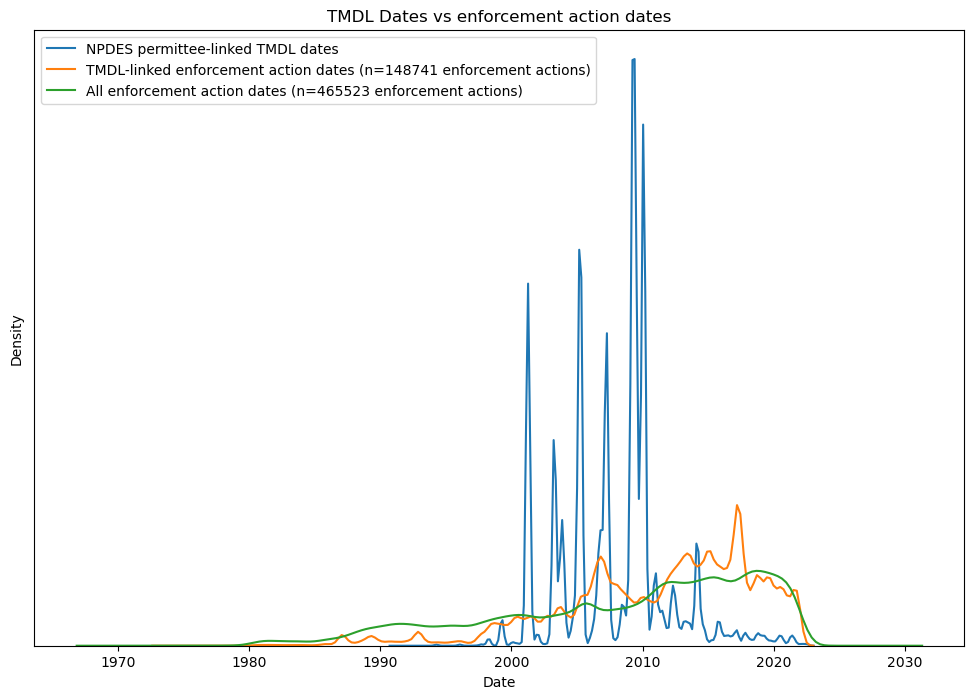

In [6]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('Density')
plt.xlabel('Date')
plt.yticks([])
sns.kdeplot(data=tmdls_enforcements_merged, x='TMDLDate', label='NPDES permittee-linked TMDL dates');
sns.kdeplot(data=tmdls_enforcements_merged, x='enforcement_action_date', label='TMDL-linked enforcement action dates (n=' + str(len(tmdls_enforcements_merged.drop_duplicates('enf_identifier'))) + ' enforcement actions)');
sns.kdeplot(data=npdes_enforcement_actions, x='enforcement_action_date', label='All enforcement action dates (n=' + str(len(npdes_enforcement_actions.drop_duplicates('enf_identifier'))) + ' enforcement actions)');
plt.title('TMDL Dates vs enforcement action dates');
plt.legend();

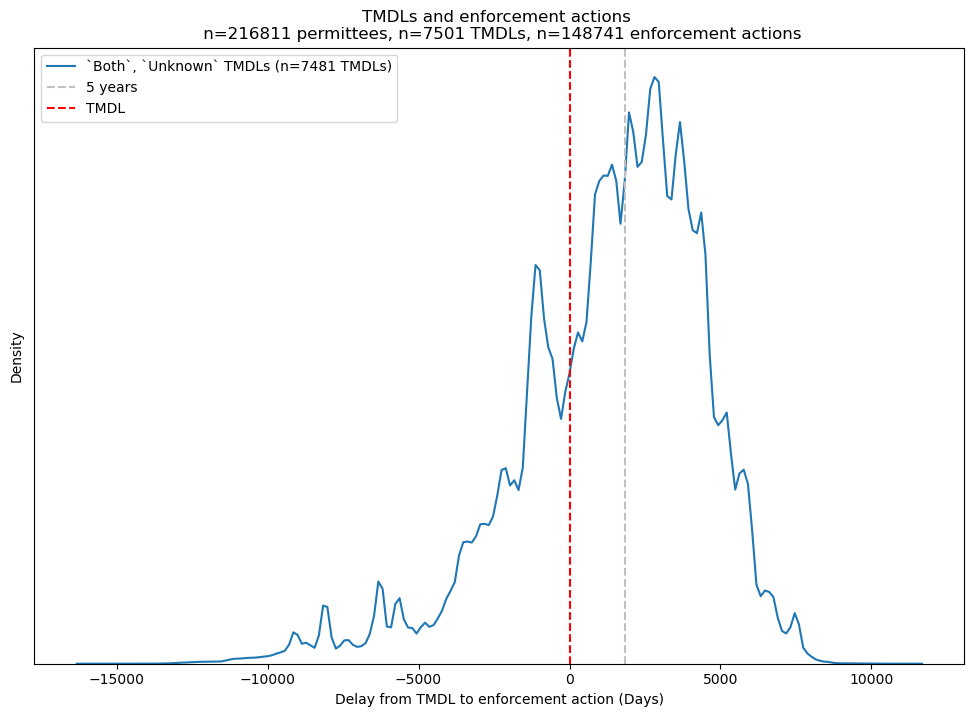

In [7]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.xlabel('Delay from TMDL to enforcement action (Days)')
sns.kdeplot(data=tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode'] != 'Point source'], x='enforcement_action_delay', label='`Both`, `Unknown` TMDLs (n=' + str(len(tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode'] != 'Point source'].drop_duplicates('actionIdentifier'))) + ' TMDLs)');
sns.kdeplot(data=tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode']=='Point Source'], x='enforcement_action_delay', label='Point source TMDLs' + str(len(tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode'] == 'Point source'].drop_duplicates('actionIdentifier'))));
plt.yticks([])
plt.axvline(x=365*5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('TMDLs and enforcement actions \n n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('actionIdentifier'))) + ' TMDLs, n=' + str(len(tmdls_enforcements_merged.drop_duplicates('enf_identifier'))) + ' enforcement actions');
plt.legend();

What about penalty amounts?

In [58]:
# Calculate years since TMDL
tmdls_enforcements_merged.dropna(subset=['enforcement_action_date', 'TMDLDate'], inplace=True)

tmdls_enforcements_merged['years_since_TMDL'] = tmdls_enforcements_merged['enforcement_action_date'].dt.year - tmdls_enforcements_merged['TMDLDate'].dt.year

In [97]:
# Calculate mean penalty amount for each year relative to a TMDL
yearly_fed_penalties = tmdls_enforcements_merged.dropna(subset=['fed_penalty_assessed_amt']).groupby('years_since_TMDL', as_index=False).agg(mean_penalty=pd.NamedAgg(column='fed_penalty_assessed_amt', aggfunc=pd.DataFrame.mean), penalty_se=pd.NamedAgg(column='fed_penalty_assessed_amt', aggfunc=pd.DataFrame.sem), penalty_n_enforcements=pd.NamedAgg(column='enf_identifier', aggfunc=pd.Series.nunique))

yearly_state_local_penalties = tmdls_enforcements_merged.dropna(subset=['state_local_penalty_amt']).groupby('years_since_TMDL', as_index=False).agg(mean_penalty=pd.NamedAgg(column='state_local_penalty_amt', aggfunc=pd.DataFrame.mean), penalty_se=pd.NamedAgg(column='state_local_penalty_amt', aggfunc=pd.DataFrame.sem), penalty_n_enforcements=pd.NamedAgg(column='enf_identifier', aggfunc=pd.Series.nunique))

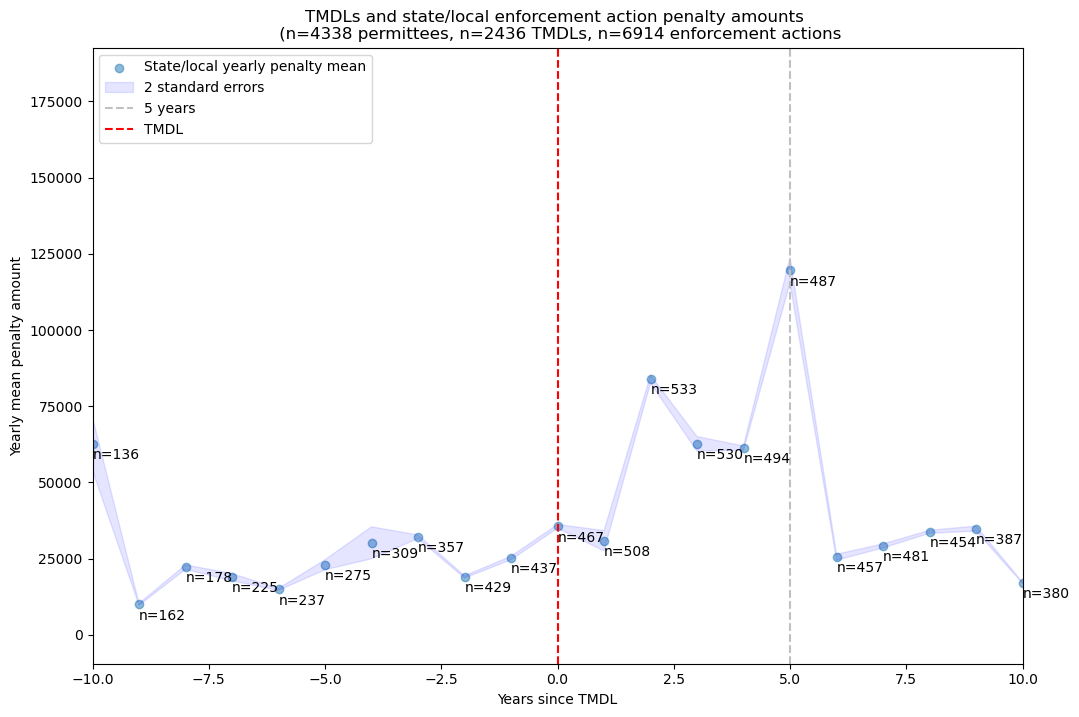

In [113]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.xlabel('Years since TMDL')
plt.scatter(yearly_state_local_penalties['years_since_TMDL'], yearly_state_local_penalties['mean_penalty'], label='State/local yearly penalty mean', alpha=0.5);
plt.fill_between(yearly_state_local_penalties['years_since_TMDL'], (yearly_state_local_penalties['mean_penalty']-1.98*yearly_state_local_penalties['penalty_se']), (yearly_state_local_penalties['mean_penalty']+1.98*yearly_state_local_penalties['penalty_se']), color='b', alpha=.1, label='2 standard errors')

# Annotate points with sample sizes
for i, txt in enumerate(yearly_state_local_penalties['penalty_n_enforcements']):
    plt.annotate('n=' + str(txt), (yearly_state_local_penalties['years_since_TMDL'][i], yearly_state_local_penalties['mean_penalty'][i]-5000))

plt.xlim((-10, 10))
plt.ylabel('Yearly mean penalty amount')
plt.axvline(x=5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('TMDLs and state/local enforcement action penalty amounts \n (n=' + str(
    len(tmdls_enforcements_merged.dropna(subset=['state_local_penalty_amt']).drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_enforcements_merged.dropna(subset=['state_local_penalty_amt']).drop_duplicates('actionIdentifier'))) + ' TMDLs, n=' + str(len(tmdls_enforcements_merged.dropna(subset=['state_local_penalty_amt']).drop_duplicates('enf_identifier'))) + ' enforcement actions')
plt.legend();

What are the summary statistics for this subset, compared to all TMDLs?

In [124]:
tmdls_enforcements_merged.dropna(subset=['state_local_penalty_amt']).drop_duplicates('enf_identifier')['state_code'].value_counts(normalize=True).head(10)

PA    0.209141
NC    0.121927
NY    0.100087
TX    0.077235
MD    0.062482
WV    0.044692
TN    0.037460
FL    0.034134
SC    0.032832
VA    0.029071
Name: state_code, dtype: float64

In [128]:
tmdls['state_code'].value_counts(normalize=True).head(10)

PA    0.804358
WV    0.018358
WA    0.017619
CA    0.017590
VA    0.016180
MI    0.015788
MT    0.010698
KS    0.010576
MN    0.009648
TN    0.008129
Name: state_code, dtype: float64

In [125]:
tmdls_enforcements_merged.dropna(subset=['state_local_penalty_amt'])['pollutantName'].value_counts(normalize=True).head()

IRON         0.214542
ALUMINUM     0.213960
MANGANESE    0.193667
PH           0.140086
SEDIMENT     0.082692
Name: pollutantName, dtype: float64

In [129]:
tmdls['pollutantName'].value_counts(normalize=True).head(10)

IRON                                0.201872
ALUMINUM                            0.191298
MANGANESE                           0.189365
PH                                  0.123734
SEDIMENT                            0.070586
PHOSPHORUS                          0.028822
POLYCHLORINATED BIPHENYLS (PCBS)    0.023743
FECAL COLIFORM                      0.023503
ESCHERICHIA COLI (E. COLI)          0.017987
PHOSPHORUS, TOTAL                   0.015959
Name: pollutantName, dtype: float64

In [126]:
tmdls_enforcements_merged.dropna(subset=['state_local_penalty_amt'])['agency'].value_counts(normalize=True).head()

State    0.997225
EPA      0.002775
Name: agency, dtype: float64

What happens if we exclude Pennsylvania from the analysis?

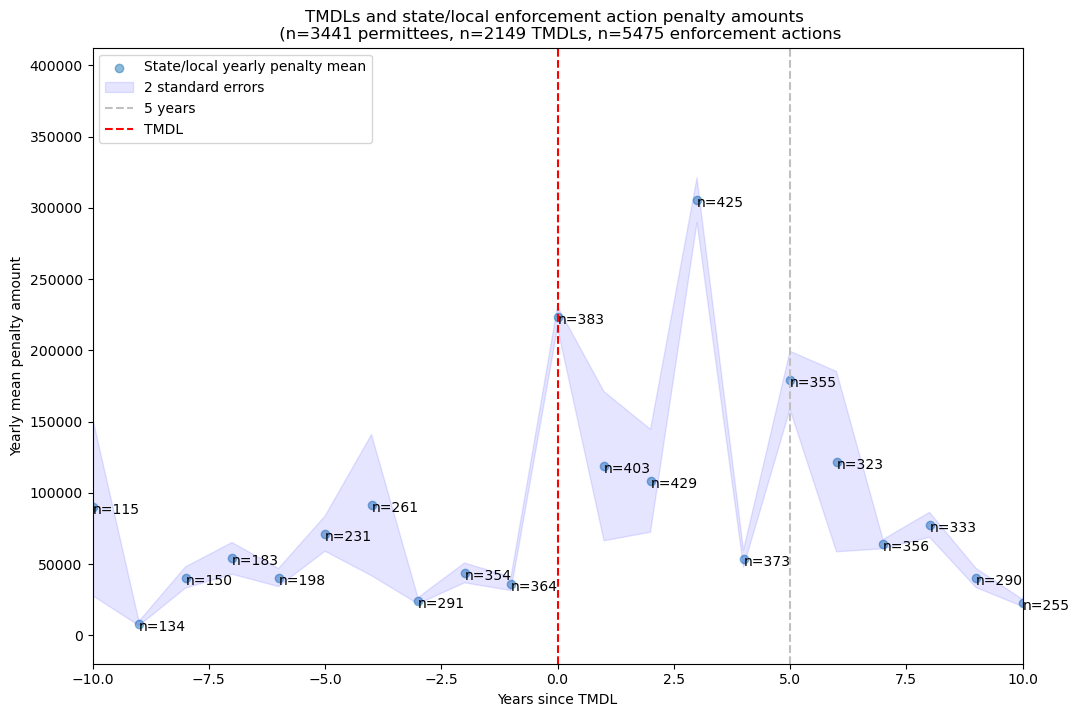

In [119]:
to_plot = tmdls_enforcements_merged[tmdls_enforcements_merged['state_code']!='PA'].dropna(subset=['state_local_penalty_amt']).groupby('years_since_TMDL', as_index=False).agg(mean_penalty=pd.NamedAgg(column='state_local_penalty_amt', aggfunc=pd.DataFrame.mean), penalty_se=pd.NamedAgg(column='state_local_penalty_amt', aggfunc=pd.DataFrame.sem), penalty_n_enforcements=pd.NamedAgg(column='enf_identifier', aggfunc=pd.Series.nunique))

plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.xlabel('Years since TMDL')
plt.scatter(to_plot['years_since_TMDL'], to_plot['mean_penalty'], label='State/local yearly penalty mean', alpha=0.5);
plt.fill_between(to_plot['years_since_TMDL'], (to_plot['mean_penalty']-1.98*to_plot['penalty_se']), (to_plot['mean_penalty']+1.98*to_plot['penalty_se']), color='b', alpha=.1, label='2 standard errors')

# Annotate points with sample sizes
for i, txt in enumerate(to_plot['penalty_n_enforcements']):
    plt.annotate('n=' + str(txt), (to_plot['years_since_TMDL'][i], to_plot['mean_penalty'][i]-5000))

plt.xlim((-10, 10))
plt.ylabel('Yearly mean penalty amount')
plt.axvline(x=5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('TMDLs and state/local enforcement action penalty amounts \n (n=' + str(
    len(tmdls_enforcements_merged[tmdls_enforcements_merged['state_code']!='PA'].dropna(subset=['state_local_penalty_amt']).drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_enforcements_merged[tmdls_enforcements_merged['state_code']!='PA'].dropna(subset=['state_local_penalty_amt']).drop_duplicates('actionIdentifier'))) + ' TMDLs, n=' + str(len(tmdls_enforcements_merged[tmdls_enforcements_merged['state_code']!='PA'].dropna(subset=['state_local_penalty_amt']).drop_duplicates('enf_identifier'))) + ' enforcement actions')
plt.legend();

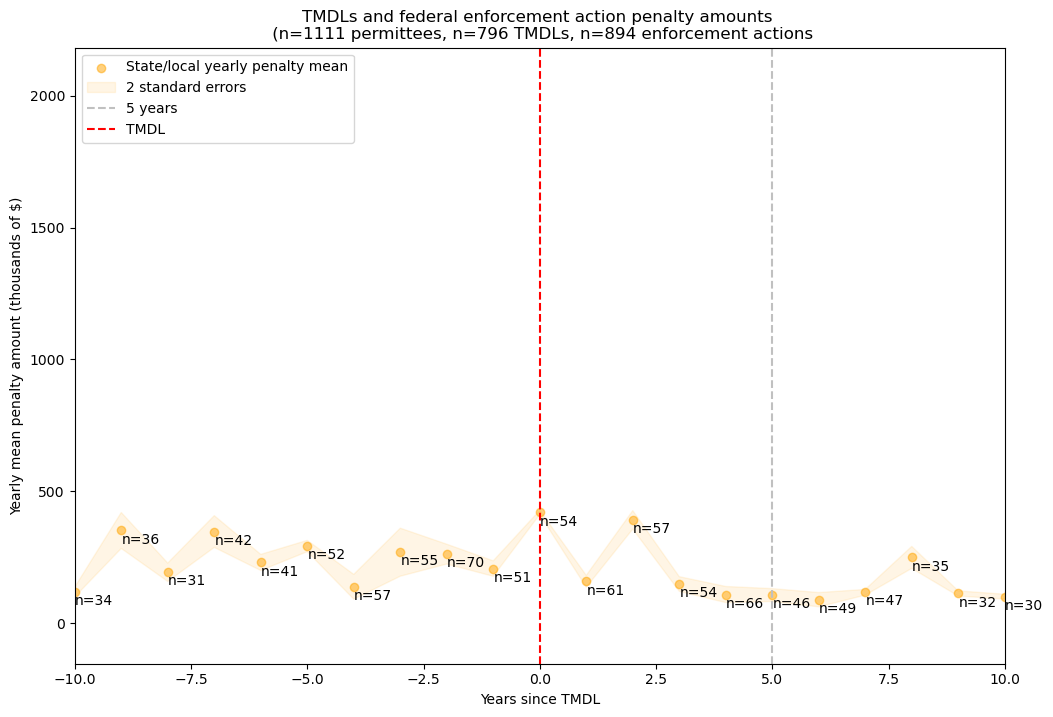

In [110]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.xlabel('Years since TMDL')
plt.scatter(yearly_fed_penalties['years_since_TMDL'], yearly_fed_penalties['mean_penalty']/1000, label='State/local yearly penalty mean', alpha=0.5, color='orange');
plt.fill_between(yearly_fed_penalties['years_since_TMDL'], (yearly_fed_penalties['mean_penalty']/1000-1.98*yearly_fed_penalties['penalty_se']/1000), (yearly_fed_penalties['mean_penalty']/1000+1.98*yearly_fed_penalties['penalty_se']/1000), color='orange', alpha=.1, label='2 standard errors')

# Annotate points with sample sizes
for i, txt in enumerate(yearly_fed_penalties['penalty_n_enforcements']):
    plt.annotate('n=' + str(txt), (yearly_fed_penalties['years_since_TMDL'][i], yearly_fed_penalties['mean_penalty'][i]/1000-50))

plt.xlim((-10, 10))
plt.ylabel('Yearly mean penalty amount (thousands of $)')
plt.axvline(x=5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('TMDLs and federal enforcement action penalty amounts \n (n=' + str(
    len(tmdls_enforcements_merged.dropna(subset=['fed_penalty_assessed_amt']).drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_enforcements_merged.dropna(subset=['fed_penalty_assessed_amt']).drop_duplicates('actionIdentifier'))) + ' TMDLs, n=' + str(len(tmdls_enforcements_merged.dropna(subset=['fed_penalty_assessed_amt']).drop_duplicates('enf_identifier'))) + ' enforcement actions')
plt.legend();

Can we focus in on just enforcement actions that might plausibly be associated with misreporting?

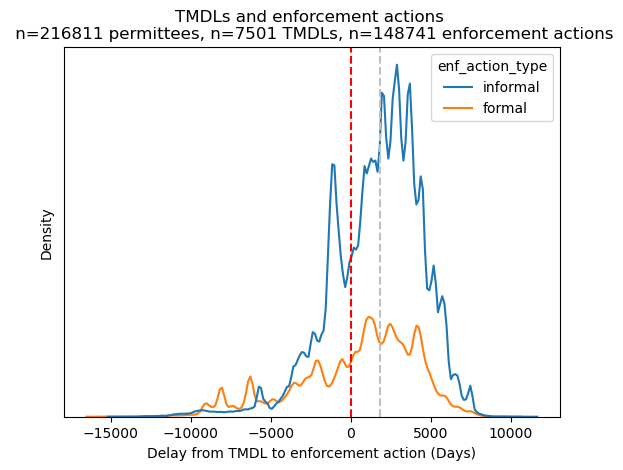

In [16]:
plt.style.use('default')
plt.xlabel('Delay from TMDL to enforcement action (Days)')
sns.kdeplot(data=tmdls_enforcements_merged, hue='enf_action_type', x='enforcement_action_delay');
plt.yticks([])
plt.axvline(x=365*5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('TMDLs and enforcement actions \n n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('actionIdentifier'))) + ' TMDLs, n=' + str(len(tmdls_enforcements_merged.drop_duplicates('enf_identifier'))) + ' enforcement actions');

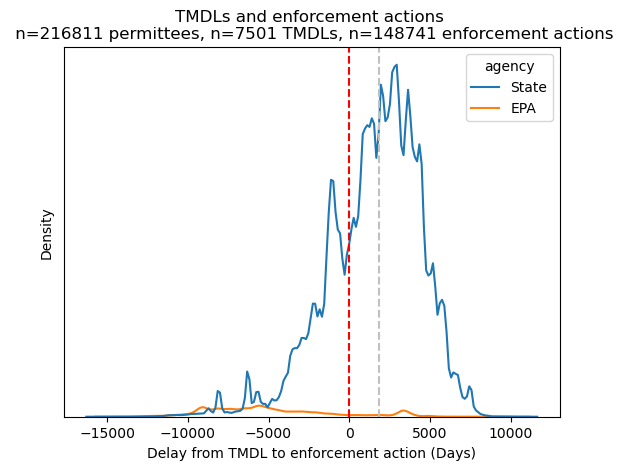

In [15]:
plt.style.use('default')
plt.xlabel('Delay from TMDL to enforcement action (Days)')
sns.kdeplot(data=tmdls_enforcements_merged, hue='agency', x='enforcement_action_delay');
plt.yticks([])
plt.axvline(x=365*5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('TMDLs and enforcement actions \n n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('actionIdentifier'))) + ' TMDLs, n=' + str(len(tmdls_enforcements_merged.drop_duplicates('enf_identifier'))) + ' enforcement actions');